In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import pandas as pd
import gspread
from oauth2client.service_account import ServiceAccountCredentials

# Function to manage data from Google sheets

In [58]:
def GS2dict():
    # Google API stuff
    scope = ["https://www.googleapis.com/auth/drive"]
    creds = ServiceAccountCredentials.from_json_keyfile_name('config/gcp-credentials.json', scope)
    client = gspread.authorize(creds)
    runs = ['run2', 'run3', 'run4', 'run5', 'run6']
    D = defaultdict(lambda: [])
    for run in runs:
        sheet = client.open('results_layers').worksheet(run)
        df = pd.DataFrame(sheet.get_all_records())
        D['SST2'].append(list(df['SST2'])) 
        D['QQP'].append(list(df['QQP']))
        D['MNLI'].append(list(df['MNLI']))
    for key in D.keys():
        D[key] = np.array(D[key]).transpose() #transpose
    return D

In [59]:
D = GS2dict()

In [60]:
stds, means = {}, {}
for key in D.keys():
    stds[key] = np.std(D[key], axis=1)
    #stds[key] = 0.02 + np.random.rand(13) * 0.02
    means[key] = np.mean(D[key], axis=1)

# Plot performance of layers with standard deviation

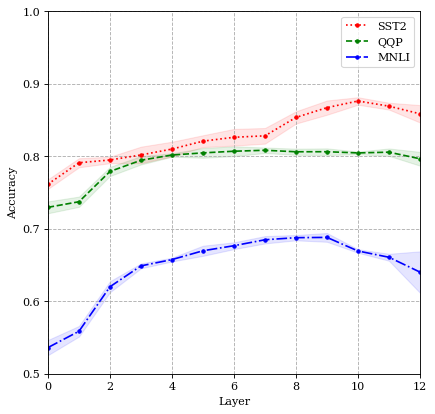

In [69]:
x = list(range(0, 13))
style = {'SST2': ':', 'MNLI': '-.', 'QQP': '--'}
colors = {'SST2': 'r', 'MNLI': 'b', 'QQP': 'g'}

fig = plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams["font.family"] = "serif"
for key in D.keys():
    plt.plot(x, means[key], style[key], label=key, marker='.', color=colors[key])
    plt.fill_between(x, means[key] + stds[key], means[key] - stds[key], alpha=0.1, color=colors[key])
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Layer')
plt.grid(linestyle='--')
fig.axes[0].set_xlim([0, 12])
fig.axes[0].set_ylim([0.5, 1.0])
plt.savefig('figures/fig_layers.png')

# Functions to read .txt files and extract results

In [113]:
from ast import literal_eval
from collections import defaultdict
import os
import glob
import matplotlib

def text2dict(text):
    C = "Full test set compressions: "
    L = "Full test set losses: "
    start_C = text.find(C) + len(C)
    end_C = start_C + text[start_C:].find('}') + 1
    start_L = text.find(L) + len(L)
    end_L = start_L + text[start_L:].find('}') + 1
    compression_dict = literal_eval(text[start_C:end_C])
    eval_dict = literal_eval(text[start_L:end_L])
    results = {}
    for key in compression_dict.keys():
        results[key] = (compression_dict[key], eval_dict[key])
    return results

def listdir_nohidden(path):
    return glob.glob(os.path.join(path, '*'))

def plot_points(list_of_tuples, label=None, normalize=True, linestyle='--', color=None, alpha=None, marker=None):
    x = np.array([t[0] for t in list_of_tuples])
    y = np.array([t[1] for t in list_of_tuples])
    if normalize:
        y /= y[list(x).index(1.0)]
    y = np.array([v for _,v in sorted(zip(x,y))])  # order w.r.t compression
    x.sort()
    plt.plot(x, y, linestyle, label=label, color=color, alpha=alpha, marker=marker)

def read_file_in_dir(directory, layer=None, tasks=['SST2', 'MNLI', 'QQP'], original_performance=None):
    files = listdir_nohidden(directory)
    all_results = defaultdict(lambda: {'SST2':[], 'MNLI':[], 'QQP':[]})
    for path in files:
        with open(path, 'r') as f:
            txt = f.read()
        #print(path)
        R = text2dict(txt)
        name = os.path.basename(path).strip('.txt')
        for t in ['fixed', 'hard', 'agg0', 'agg10', 'agg', 'rand', 'freq']:
            if t in name:
                kind = t
                break
        for task in tasks:
            all_results[kind][task].append(R[task])
    
    layer_key = f"layer{layer}"
    for kind in all_results.keys():
        for task in tasks:
            all_results[kind][task].append(original_performance[layer_key][task])
            
    return all_results

# Loop for docs in a directory and plot them to compare different chunking strategies

In [121]:
original_performance = {'layer0': {}, 'layer10': {}}
#original_performance['layer0']['SST2'] = (1.0, 0.767034174)
#original_performance['layer0']['MNLI'] = (1.0, 0.5451)
#original_performance['layer0']['QQP'] = (1.0, 0.7386125454)
#original_performance['layer10']['SST2'] = (1.0, 0.883326997)
#original_performance['layer10']['MNLI'] = (1.0, 0.6718666667)
#original_performance['layer10']['QQP'] = (1.0, 0.8057614641)

# New Good Performances
original_performance['layer0']['SST2'] = (1.0, 0.8619101930469311)
original_performance['layer10']['SST2'] = (1.0, 0.9043213787859586)

original_performance['layer0']['MNLI'] = (1.0, 0.5668)
original_performance['layer10']['MNLI'] = (1.0, 0.7105333333333334)

original_performance['layer0']['QQP'] = (1.0, 0.787)
original_performance['layer10']['QQP'] = (1.0, 0.853)



name0 = 'preliminary-lstm0'
name10 = 'preliminary-lstm10'
directory0 = f"/Users/sergicastellasape/Desktop/{name0}/"
directory10 = f"/Users/sergicastellasape/Desktop/{name10}/"
all_results_L0 = read_file_in_dir(directory0, layer=0, tasks=['SST2', 'MNLI', 'QQP'], original_performance=original_performance)
all_results_L10 = read_file_in_dir(directory10, layer=10, tasks=['SST2', 'MNLI', 'QQP'], original_performance=original_performance)

all_results_L0.keys()

dict_keys(['hard', 'agg10', 'agg0'])

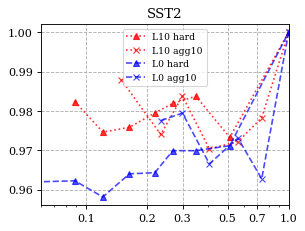

In [120]:
fig = plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
line = {'fixed':'-.', 'hard':'--', 'freq':':', 'agg10':'-.', 'agg0':'-.', 'agg':'-.','rand':':'}
marker = {'fixed':'.', 'hard':'^', 'freq':'1', 'agg10':'x', 'agg0':'x', 'agg':'x', 'rand': '*'}
#kinds = ['fixed', 'hard', 'freq', 'agg', 'rand']
#kinds = ['hard', 'freq', 'fixed', 'agg']
kinds = ['hard', 'agg10', 'agg0']
#kinds = ['hard']
#line = {'agg':'-.'}
plt.rcParams["font.family"] = "serif"
#plt.tight_layout()
task = "SST2"
for kind in kinds:
    plot_points(all_results_L10[kind][task],
                label=f'L10 ' + kind, 
                linestyle=':' , 
                color='r', 
                alpha=0.8,
                marker=marker[kind])
for kind in kinds:
    plot_points(all_results_L0[kind][task], 
                    label= f'L0 ' + kind, 
                    linestyle='--' , 
                    color='b', 
                    alpha=0.7,
                    marker=marker[kind])
#     plot_points(all_results[kind]['QQP'], 
#                 label=kind + ' QQP', 
#                 linestyle=line[kind], 
#                 color='g', 
#                 alpha=0.8,
#                 marker=marker[kind])
#     plot_points(all_results[kind]['MNLI'], 
#                 label=kind + ' MNLI', 
#                 linestyle=line[kind], 
#                 color='b', 
#                 alpha=0.8,
#                 marker=marker[kind])
plt.title(task)
plt.legend(fontsize='small')
plt.xscale('log')
plt.grid(linestyle='--')
fig.axes[0].set_xlim([0.06, 1.0])
plt.xticks([0.1, 0.2, 0.3, 0.5, 0.7, 1.0])
fig.axes[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.ylabel('Accuracy Degradation')
#lt.xlabel('Compression Ratio')
#plt.savefig(f'figures/{name}.png')
#plt.savefig(f'figures/{task}-rand-rand-finetuned.png')

# Only results from random chunking + random generation

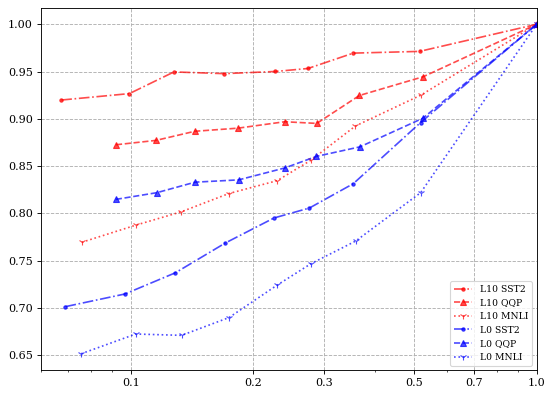

In [103]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
line = {'SST2':'-.', 'QQP':'--', 'MNLI':':',}
marker = {'SST2':'.', 'QQP':'^', 'MNLI':'1'}
#kinds = ['fixed', 'hard', 'freq', 'agg', 'rand']
#kinds = ['hard', 'freq', 'fixed', 'agg']
kinds = ['rand']
#kinds = ['hard']
#line = {'agg':'-.'}
plt.rcParams["font.family"] = "serif"
#plt.tight_layout()
tasks = ["SST2", "QQP", "MNLI"]
for task in tasks:
    plot_points(all_results_L10['rand'][task],
                label=f'L10 ' + task, 
                linestyle=line[task] , 
                color='r', 
                alpha=0.7,
                marker=marker[task])
for task in tasks:
    plot_points(all_results_L0['rand'][task], 
                    label= f'L0 ' + task, 
                    linestyle=line[task], 
                    color='b', 
                    alpha=0.7,
                    marker=marker[task])
#     plot_points(all_results[kind]['QQP'], 
#                 label=kind + ' QQP', 
#                 linestyle=line[kind], 
#                 color='g', 
#                 alpha=0.8,
#                 marker=marker[kind])
#     plot_points(all_results[kind]['MNLI'], 
#                 label=kind + ' MNLI', 
#                 linestyle=line[kind], 
#                 color='b', 
#                 alpha=0.8,
#                 marker=marker[kind])
#plt.title(task)
plt.legend(fontsize='small')
plt.xscale('log')
plt.grid(linestyle='--')
fig.axes[0].set_xlim([0.06, 1.0])
plt.xticks([0.1, 0.2, 0.3, 0.5, 0.7, 1.0])
fig.axes[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.ylabel('Accuracy Degradation')
#lt.xlabel('Compression Ratio')
#plt.savefig(f'figures/{name}.png')
plt.savefig(f'figures/rand-rand-finetuned.png')

# Function to read files from the skip-ablation

In [106]:
def read_file_skip_in_dir(directory, tasks=['SST2', 'MNLI', 'QQP'], layer=None, original_performance=None):
    files = listdir_nohidden(directory)
    all_results = defaultdict(lambda: {'SST2':[], 'MNLI':[], 'QQP':[]})
    for path in files:
        with open(path, 'r') as f:
            txt = f.read()
        #print(path)
        R = text2dict(txt)
        name = os.path.basename(path).strip('.txt')
        for s in ['skip1', 'skip3', 'skip5', 'skip10']:
            if s in name:
                skip = s      
        for task in tasks:
            all_results[skip][task].append(R[task])
    layer_key = f"layer{layer}"
    for skip in all_results.keys():
        for task in tasks:
            all_results[skip][task].append(original_performance[layer_key][task])
            
    return all_results

# Loop for different skip settings and plot to compare

In [139]:
original_performance = {'layer0': {}, 'layer10': {}}
#original_performance['layer0']['SST2'] = (1.0, 0.767034174)
#original_performance['layer0']['MNLI'] = (1.0, 0.5451)
#original_performance['layer0']['QQP'] = (1.0, 0.7386125454)
#original_performance['layer10']['SST2'] = (1.0, 0.883326997)
#original_performance['layer10']['MNLI'] = (1.0, 0.6718666667)
#original_performance['layer10']['QQP'] = (1.0, 0.8057614641)

# New Good Performances
original_performance['layer0']['SST2'] = (1.0, 0.8619101930469311)
original_performance['layer10']['SST2'] = (1.0, 0.9043213787859586)

original_performance['layer0']['MNLI'] = (1.0, 0.5668)
original_performance['layer10']['MNLI'] = (1.0, 0.7105333333333334)

original_performance['layer0']['QQP'] = (1.0, 0.787)
original_performance['layer10']['QQP'] = (1.0, 0.853)



name0 = 'gold-layer0-skip-ablation'
name10 = 'gold-layer10-skip-ablation'
directory0 = f"/Users/sergicastellasape/Desktop/{name0}/"
directory10 = f"/Users/sergicastellasape/Desktop/{name10}/"
all_results0 = read_file_skip_in_dir(directory0, 
                                    tasks=['SST2', 'MNLI', 'QQP'], 
                                    layer=0, 
                                    original_performance=original_performance)
all_results10 = read_file_skip_in_dir(directory10, 
                                      tasks=['SST2', 'MNLI', 'QQP'], 
                                      layer=10,
                                      original_performance=original_performance)
#all_results['skip1']

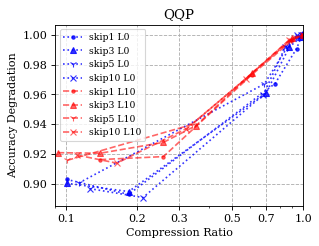

In [143]:
fig = plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
line = {'skip1': '-.', 'skip3':'--', 'skip5':':', 'skip10':'-.'}
marker = {'skip1':'.', 'skip3':'^', 'skip5':'1', 'skip10':'x'}
colors = {'skip1':'c', 'skip3':'m', 'skip5':'y', 'skip10':'r'}
#line = {'agg':'-.'}
plt.rcParams["font.family"] = "serif"
task = "QQP"
for kind in line.keys():
    plot_points(all_results0[kind][task], 
                label=kind + ' L0', 
                linestyle=':', 
                color='b', 
                normalize=True,
                alpha=0.8,
                marker=marker[kind])
for kind in line.keys():
    plot_points(all_results10[kind][task], 
                label=kind + ' L10', 
                linestyle='--' , 
                color='r', 
                normalize=True,
                alpha=0.6,
                marker=marker[kind])
#     plot_points(all_results[kind]['QQP'], 
#                 label=kind + ' QQP', 
#                 linestyle=':', 
#                 color=colors[kind], 
#                 normalize=True,
#                 alpha=0.8,
#                 marker='^')
#     plot_points(all_results[kind]['MNLI'], 
#                 label=kind + ' MNLI', 
#                 linestyle='--', 
#                 color=colors[kind], 
#                 normalize=True,
#                 alpha=0.8,
#                 marker='.',)
plt.title(task)
plt.legend(fontsize='small')
plt.xscale('log')
plt.grid(linestyle='--')
fig.axes[0].set_xlim([0.09, 1.0])
plt.xticks([0.1, 0.2, 0.3, 0.5, 0.7, 1.0])
fig.axes[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylabel('Accuracy Degradation')
plt.xlabel('Compression Ratio')
plt.savefig(f'figures/{task}-skip-ablation.png')

In [80]:
import time
walltime = 1.5 # seconds
wallsteps = 2000
global_counter = 2000
initial_time = time.time()
time.sleep(1)
finished_training = True if (
    (time.time() - initial_time) > walltime or
        global_counter >= wallsteps
) else False
finished_training

True